# pyfabric example 04: 3D register QCT to HR-pQCT dataset

Created on:  16.06.2025 <br />
Last update: 11.07.2025 <br />

- By: [Gianluca Iori](https://github.com/gianthk), 2024
- Data source: QCT and HR-pQCT datasets were collected within the ANR-DFG TaCoSound project.
- Code license: MIT
- Narrative license: CC-BY-NC-SA

---
## Aims
1. Load and inspect QCT and HR-pQCT datasets of the proximal femur using simpleITK
2. detect alignment cement markers on QCT image
3. resample QCT dataset to isotropic voxel size
4. apply median filter to QCT dataset
5. compute transformation matrices for QCT to HR-pQCT image registration
6. apply 3D affine registration transformation to register QCT data to HR-pQCT

## Registered datasets
- 2019_L
- 1996_R

---
## Configuration and imports

In [2]:
import os
import sys

In [3]:
# # gianthk@thkdebian
# sys.path.append('/home/gianthk/PycharmProjects/pyfabric')
# sys.path.append('/home/gianthk/PycharmProjects/BEATS/recon_utils')

In [3]:
# terminus
sys.path.append('/usr/terminus/data-xrm-01/stamplab/users/giiori/code/pyfabric')
sys.path.append('/usr/terminus/data-xrm-01/stamplab/users/giiori/code/ORMIR_XCT')
sys.path.append('/usr/terminus/data-xrm-01/stamplab/users/giiori/code/recon_utils')

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.filters import threshold_multiotsu
from skimage import morphology
from skimage.measure import label, regionprops, regionprops_table
import heapq
import pandas as pd
import SimpleITK as sitk

from imaging_utils import periosteummask
from resources.myshow import myshow, myshow3d
from recon_utils import plot_midplanes, plot_projections
import pyfabric
from resources.pyfabric_image_utils import dist_table, markers_coors, resample_img, vectors2rotation3Dmatrix, align_with_XYplane, align_with_vectors, resample, affine_trans

astropy module not found
olefile module not found


In [5]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 6}

plt.rc('font', **font)

In [6]:
%%html
<style>
table {float:left}
</style>

## Functions definition

In [7]:
def plot_midplanes_sitk(img):
    plot_midplanes(sitk.GetArrayFromImage(img))

def plot_projections_sitk(img):
    plot_projections(sitk.GetArrayFromImage(img))

## Computational workflow
### Settings

In [ ]:
# # gianthk@thkdebian
# work_dir = '/home/gianthk'
# data_dir = '/media/gianthk/My Passport/Data/TacoSound'

In [8]:
# terminus
data_dir = "/usr/terminus/data-xrm-01/stamplab/external/tacosound/" #base-path where .mhd and .raw file is located
work_dir = '/usr/terminus/data-xrm-01/stamplab/users/giiori/2025/2025-06_supertrab_registration/'

In [12]:
output_dir = data_dir 

target_folders = [
    "1955_L",
    "1956_L",
    "1996_R",
    "2005_L",
    "2007_L",
    "2019_L"
]

isqnames = [
    "C0001577",
    "C0001577",
    "C0001808",
    "C0001577",
    "C0001577",
    "C0001524"
]

specimen_id = 2 # (2) 1996_R; (5) 2019_L - available QCT datasets: 2, 5

specimen = target_folders[specimen_id]
isqname = isqnames[specimen_id]
master_filename = 'tacosound_master_all.csv'
master_filename = os.path.join(data_dir, master_filename)

input_file_HR = os.path.join(data_dir, 'HR-pQCT_II/00_resampled_data', specimen, isqname, '.ISQ')
input_file_HR_res = os.path.join(data_dir, 'HR-pQCT_II/00_resampled_data', specimen, (isqname + '_processed.mhd'))

# input_dir_QCT_DCM = os.path.join(data_dir, 'QCT/', ('QCTFEMUR_' + specimen.replace("_", "")), 'Q_CT_DIAGBILANZ_HR_0003') # load the original DICOM files (contain misalignmed slices)
input_dir_QCT_DCM = os.path.join(data_dir, 'QCT/', ('QCT' + specimen.replace("_", "")), 'Q_CT_DIAGBILANZ_HR_0003') # load the original DICOM files (contain misalignmed slices)
print("input_dir_QCT_DCM:", input_dir_QCT_DCM)

# input_file_QCT_fixed = os.path.join(data_dir, 'QCT', ('QCTFEMUR_' + specimen.replace("_", "")), (specimen + '_3Dslicer.mhd'))
input_file_QCT_fixed = os.path.join(data_dir, 'QCT', ('QCT' + specimen.replace("_", "")), (specimen + '_3Dslicer.mhd'))
print("input_file_QCT_fixed:", input_file_QCT_fixed)

# input_file_QCT = work_dir + '/Data/TacoSound/QCT/QCTFEMUR_2019L/slices/slice_0000.tif'

input_dir_QCT_DCM: /usr/terminus/data-xrm-01/stamplab/external/tacosound/QCT/QCT1996R/Q_CT_DIAGBILANZ_HR_0003
input_file_QCT_fixed: /usr/terminus/data-xrm-01/stamplab/external/tacosound/QCT/QCT1996R/1996_R_3Dslicer.mhd


### Read and inspect HR-pQCT input data

#### ! For the moment we use resampled data !

In [13]:
data_3D_res = sitk.ReadImage(input_file_HR_res, imageIO="MetaImageIO")

In [14]:
# print out the usual SimpleITK image characteristics
print (data_3D_res.GetSize())
print (data_3D_res.GetSpacing())
print (data_3D_res.GetOrigin())
print (data_3D_res.GetDirection())

(576, 576, 625)
(242.39930556, 242.39930556, 240.0)
(0.0, 0.0, 13656.0)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


Inspect dataset

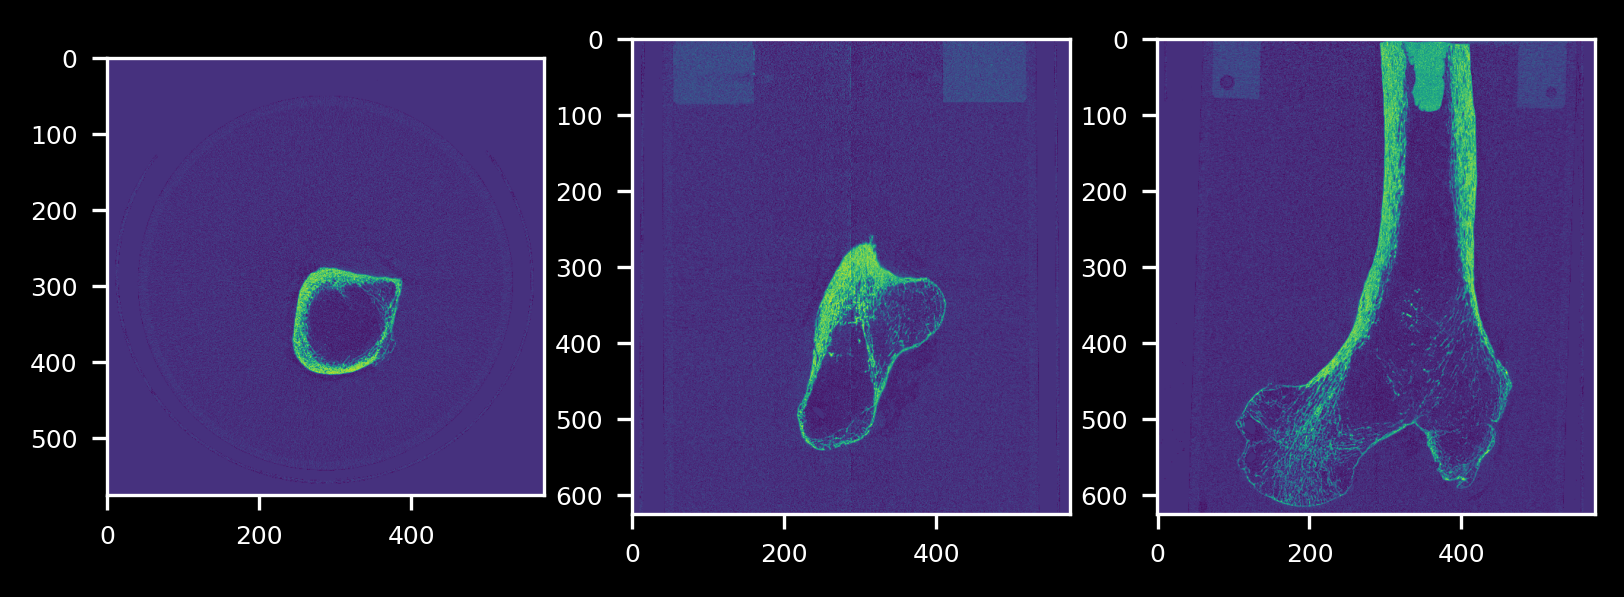

In [15]:
plot_midplanes_sitk(data_3D_res)

#### Read coordinates of cement markers
Read study master table

In [16]:
master = pd.read_csv(master_filename, sep=',') # names=column_names, dtype=float

In [18]:
master.head()

$specimen  $donor       $site $config  $mechtest $sex  $age  $side  \
0  1955_L_S    1955  femur_prox  STANCE          1    m    88   LEFT   
1  1955_R_F    1955  femur_prox    FALL          1    m    88  RIGHT   
2  1956_L_S    1956  femur_prox  STANCE          0    m    82   LEFT   
3  1956_R_S    1956  femur_prox  STANCE          0    m    82  RIGHT   
4  1958_L_F    1958  femur_prox    FALL          1    w    80   LEFT   

   $h_sample  $femurh  ... $aBMDinter    $Aneck  $BMCneck $aBMDneck   $Awards  \
0    170.570       51  ...   0.805222  7.277173  3.807238  0.523175  1.170454   
1    166.132       51  ...   0.804763  8.223714  4.365356  0.530825  1.170454   
2    153.514       43  ...   0.609684  6.127074  2.165871  0.353492  1.109387   
3    157.494       43  ...   0.634896  6.004940  2.391120  0.398192  1.027964   
4    159.090       45  ...   0.733025  5.200888  2.273541  0.437145  1.262055   

   $BMCwards  $aBMDwards  $aBMDtot    $BMCtot      $Atot  
0   0.325666    0.278239  0.739938  40.200399  54.329436  
1   0.311581    0.266206  0.733125  42.344845  57.759376  
2   0.143702    0.129533  0.491730  20.849834  42.400980  
3   0.186689    0.181610  0.528859  23.608342  44.640110  
4   0.548343    0.434484  0.605319  25.986485  42.930229  

[5 rows x 115 columns]

In [17]:
specimen_master = master[master['$specimen'].str.contains(specimen) & master['$site'].str.contains('femur_prox')]

In [18]:
specimen_master.head()

$specimen  $donor       $site $config  $mechtest $sex  $age  $side  \
19  1996_R_S    1996  femur_prox  STANCE          1    w    92  RIGHT   

    $h_sample  $femurh  ... $aBMDinter    $Aneck  $BMCneck $aBMDneck  \
19    147.667       44  ...   0.715245  4.936264  2.146954  0.434935   

     $Awards  $BMCwards  $aBMDwards  $aBMDtot    $BMCtot      $Atot  
19  1.150099    0.24099    0.209539  0.576539  21.247797  36.854044  

[1 rows x 115 columns]

In [19]:
markers_coordinates_HR = np.array([[specimen_master['$M1x'].iloc[0], specimen_master['$M1y'].iloc[0], specimen_master['$M1z'].iloc[0]],
                                  [specimen_master['$M2x'].iloc[0], specimen_master['$M2y'].iloc[0], specimen_master['$M2z'].iloc[0]],
                                  [specimen_master['$M3x'].iloc[0], specimen_master['$M3y'].iloc[0], specimen_master['$M3z'].iloc[0]],
                                  [specimen_master['$M4x'].iloc[0], specimen_master['$M4y'].iloc[0], specimen_master['$M4z'].iloc[0]],
                                  [specimen_master['$M5x'].iloc[0], specimen_master['$M5y'].iloc[0], specimen_master['$M5z'].iloc[0]]])

In [20]:
print(markers_coordinates_HR)

[[ 99.216  96.236  12.154]
 [ 95.646  66.241  11.3  ]
 [ 43.496  72.017  12.214]
 [ 45.377 101.798  13.056]
 [ 98.252  88.098  11.642]]


Check correct position of markers coordinates

In [21]:
markers_slice = int(np.mean(markers_coordinates_HR[:,2])/(1e-3*data_3D_res.GetSpacing()[2]))
markers_pixel = (markers_coordinates_HR / (1e-3*np.array(data_3D_res.GetSpacing()))).astype('uint')

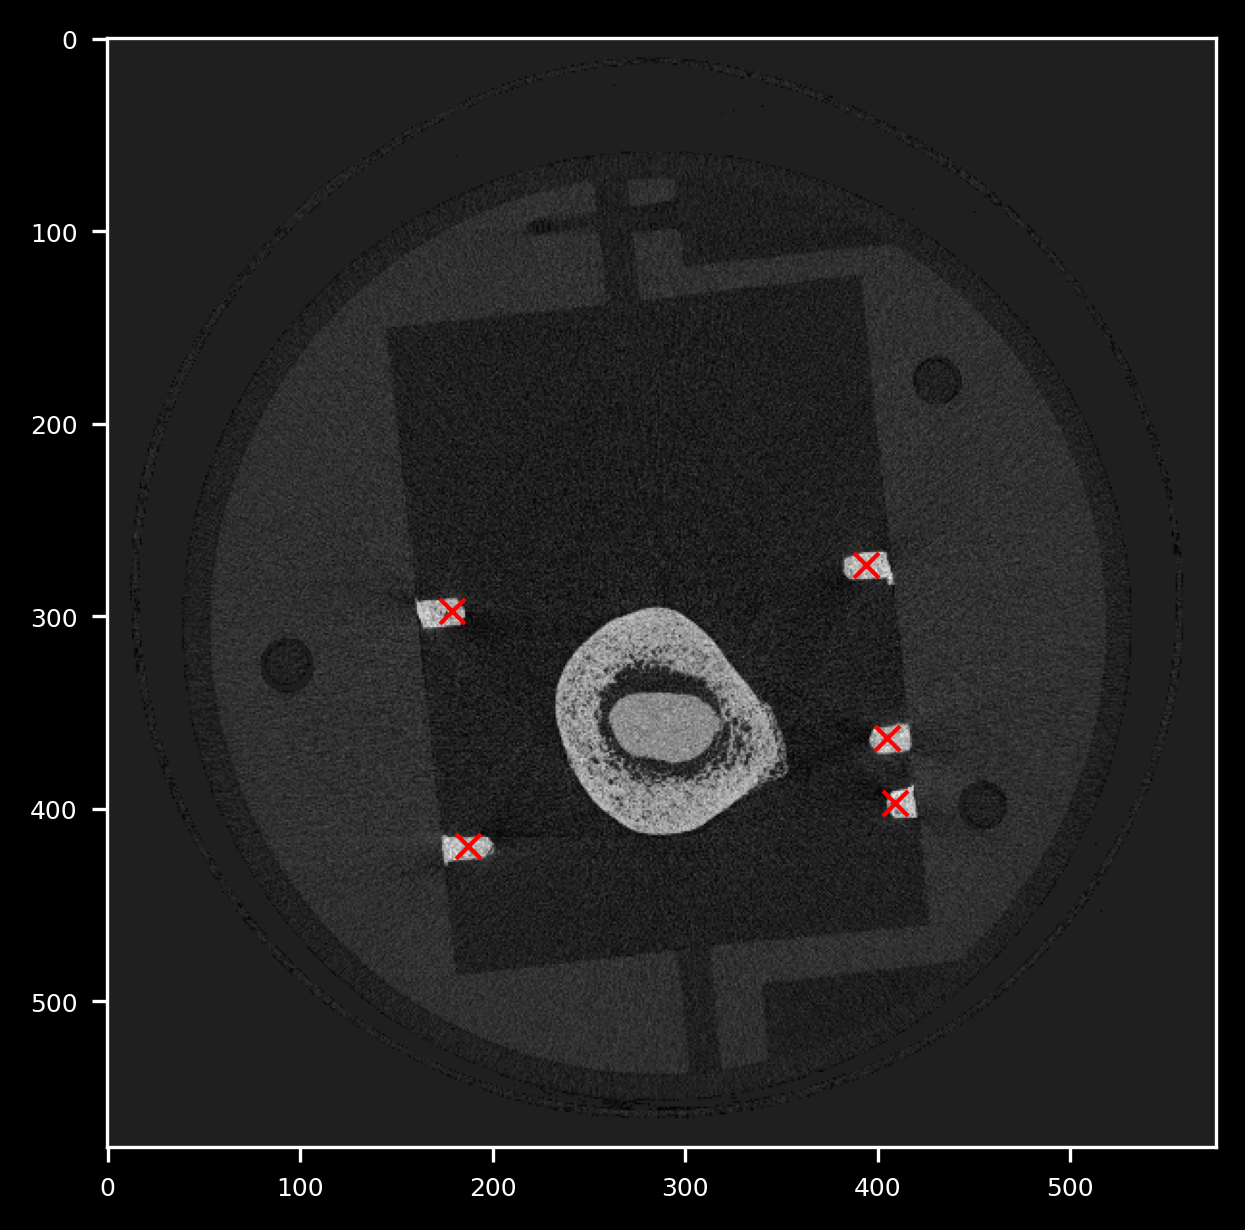

In [22]:
plt.imshow(sitk.GetArrayFromImage(data_3D_res)[markers_slice,:,:], cmap='grey')
plt.plot(markers_pixel[:,0], markers_pixel[:,1], 'xr')

### Read and inspect QCT input data
#### original QCT DICOM dataset

In [ ]:
# read QCT DICOM dataset
reader = sitk.ImageSeriesReader()

dicom_names = reader.GetGDCMSeriesFileNames(input_dir_QCT_DCM)
reader.SetFileNames(dicom_names)

data_3D_QCT = reader.Execute()

#### `.mhd` file fixed with 3Dslicer

In [25]:
data_3D_QCT = sitk.ReadImage(input_file_QCT_fixed, imageIO="MetaImageIO")

In [26]:
size_QCT = data_3D_QCT.GetSize()
print("Image size:", size_QCT[0], size_QCT[1], size_QCT[2])
vs_QCT = data_3D_QCT.GetSpacing() # it's a tuple
print("Image spacing:", vs_QCT[0], vs_QCT[1], vs_QCT[2])
dimension = data_3D_QCT.GetDimension()
print("Dimension: ", dimension)

Image size: 512 512 587
Image spacing: 0.29296874999999994 0.29296874999999994 0.3051194539249146
Dimension:  3


Inspect dataset

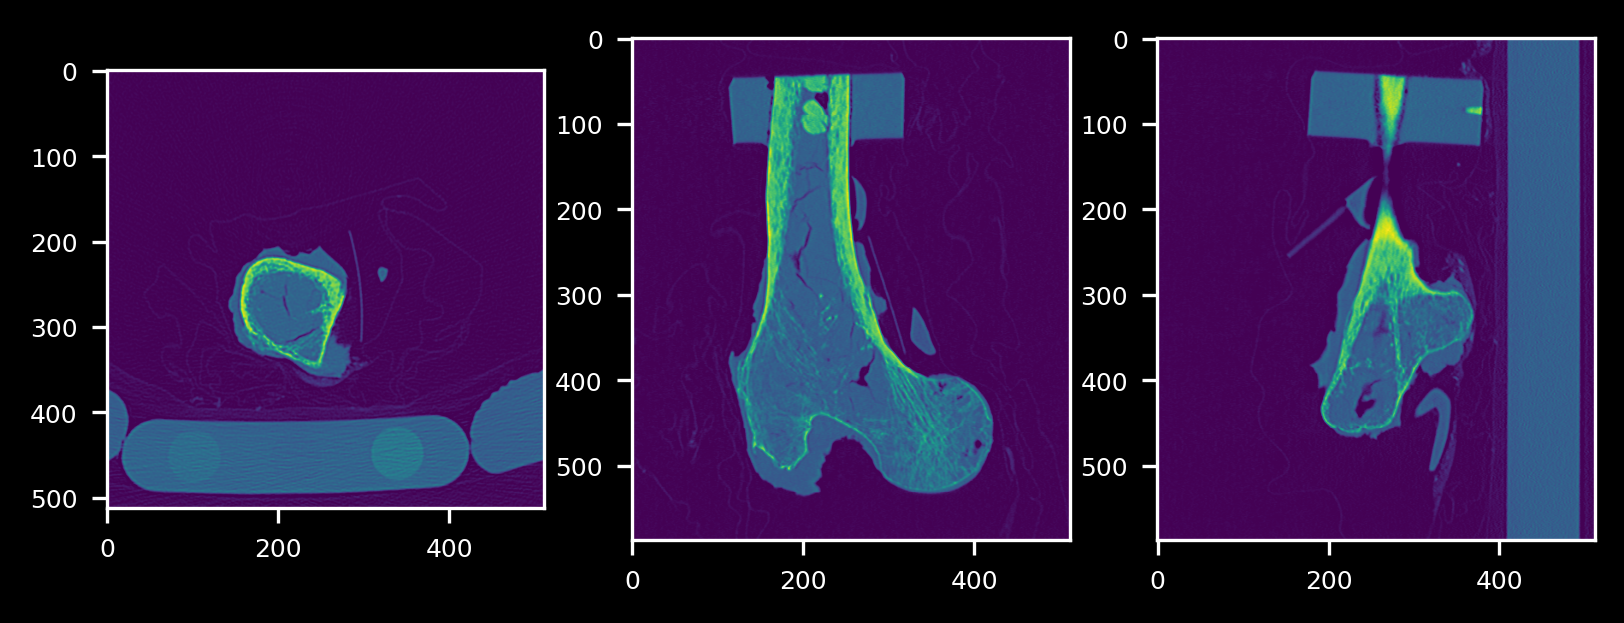

In [27]:
plot_midplanes_sitk(data_3D_QCT)

### Resample dataset to isotropic voxel size

In [28]:
# vs_QCT_new = np.array(vs_QCT)*2 # downsample with factor 2 (non isotropic!)
vs_QCT_new = np.min(vs_QCT) * np.ones([3]) # keep spacing close to the origingal one but isotropic
print(vs_QCT_new)

[0.29296875 0.29296875 0.29296875]


In [29]:
data_3D_QCT_res = resample_img(data_3D_QCT, out_spacing=vs_QCT_new)

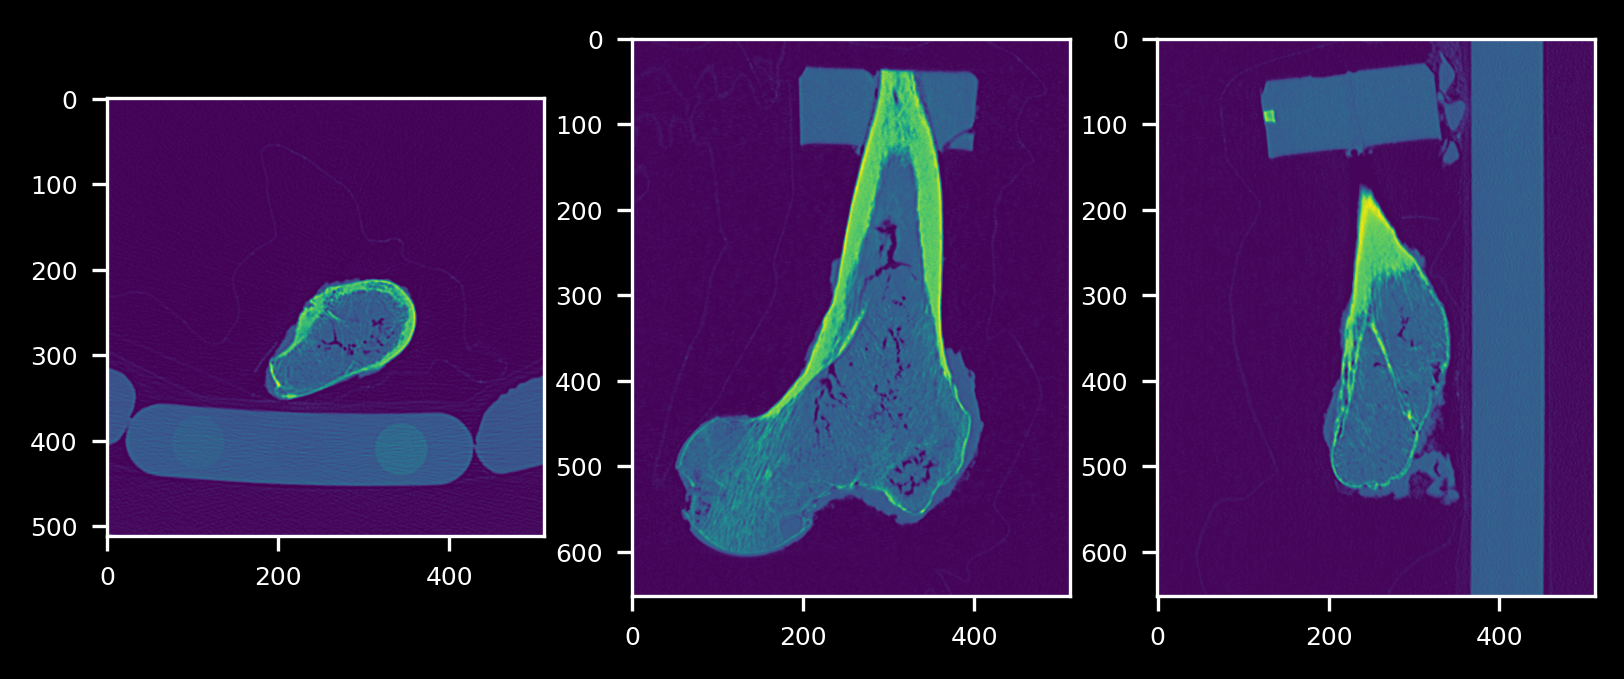

In [30]:
plot_midplanes_sitk(data_3D_QCT_res)

### Median filter
We create a filtered copy of the QCT dataset for segmentation of bone compartments

In [30]:
filter = sitk.MedianImageFilter()
filter.SetRadius(1)
data_3D_QCT_med = filter.Execute(data_3D_QCT_res)

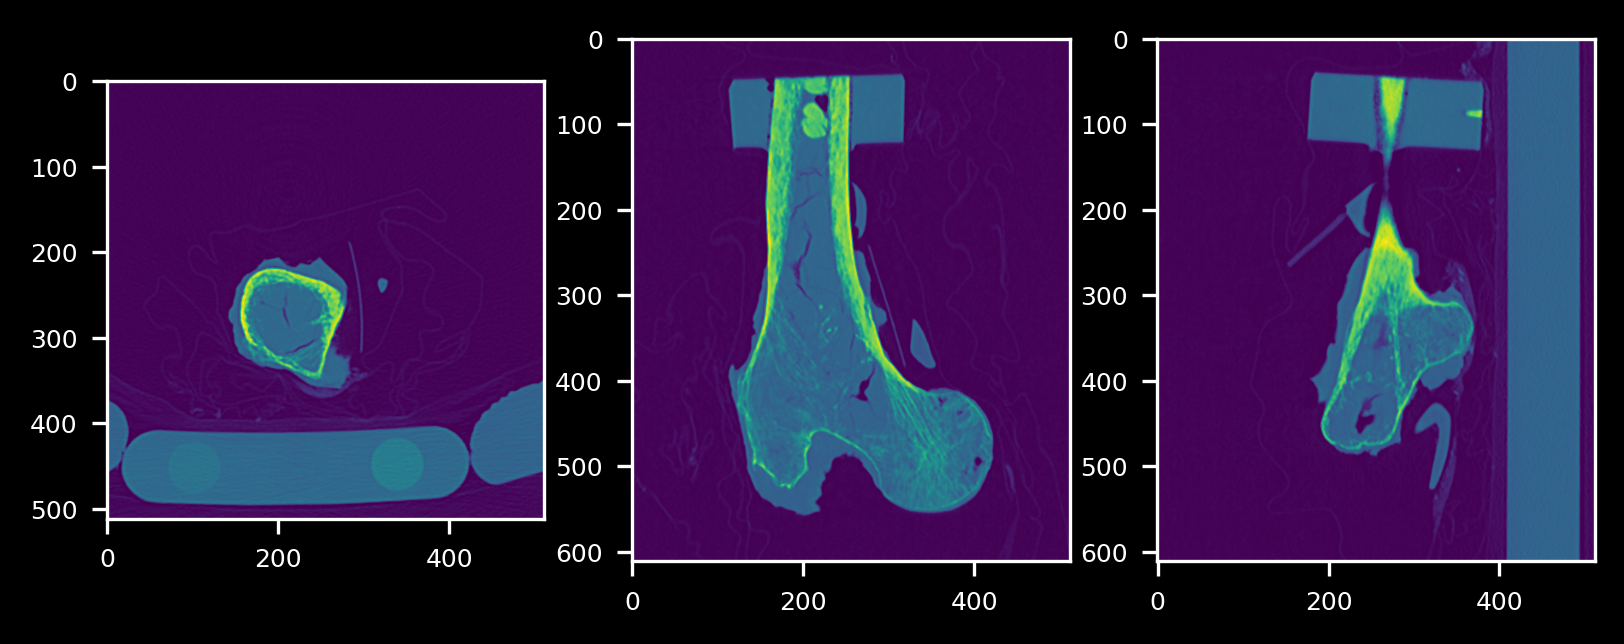

In [31]:
plot_midplanes_sitk(data_3D_QCT_med)

### Find cement markers
#### Segment markers and bone with multi otsu threshold
Multi-Otsu threshold of QCT dataset: 3 materials (backgroud, water, bone)

In [32]:
ts = threshold_multiotsu(sitk.GetArrayFromImage(data_3D_QCT_med))

Segment and perform image opening step to remove spurious voxels

In [33]:
data_3D_QCT_BW = morphology.binary_opening(sitk.GetArrayFromImage(data_3D_QCT_med) > ts[1])

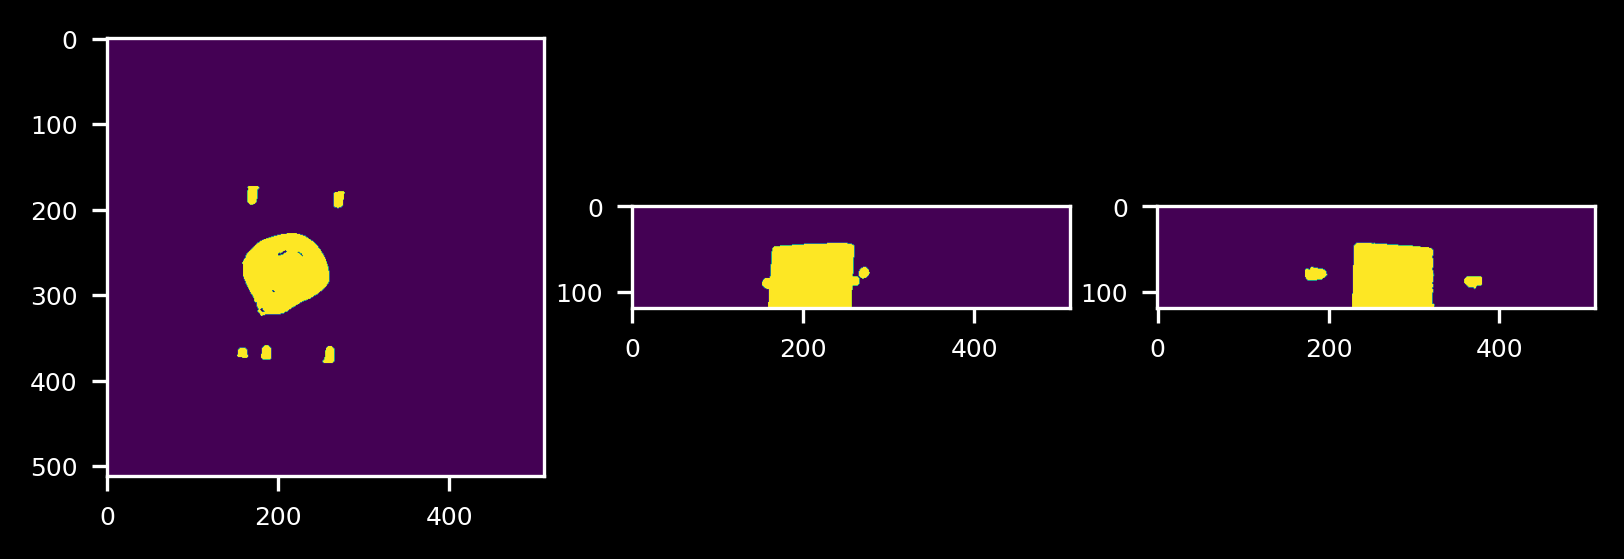

In [34]:
plot_projections(data_3D_QCT_BW[0:120,:,:])

#### Calculate markers coordinates
- QCT dataset:

In [35]:
markers_coordinates = markers_coors(data_3D_QCT_BW[0:120,:,:]) # [z, y, x]
# multiply by voxelsize and flip
markers_coordinates = np.fliplr(markers_coordinates*data_3D_QCT_med.GetSpacing()) # [x, y, z]
print(markers_coordinates)

[[ 46.28479182 107.75811999  26.43494898]
 [ 76.07902739 108.54423127  25.75822993]
 [ 79.21190976  54.9119588   23.08645374]
 [ 49.71790766  53.35349711  23.77087344]
 [ 54.40478679 107.7233356   25.92704849]]


#### Check markers positions

In [36]:
print(data_3D_QCT_med.GetSpacing())

(0.29296874999999994, 0.29296874999999994, 0.29296874999999994)


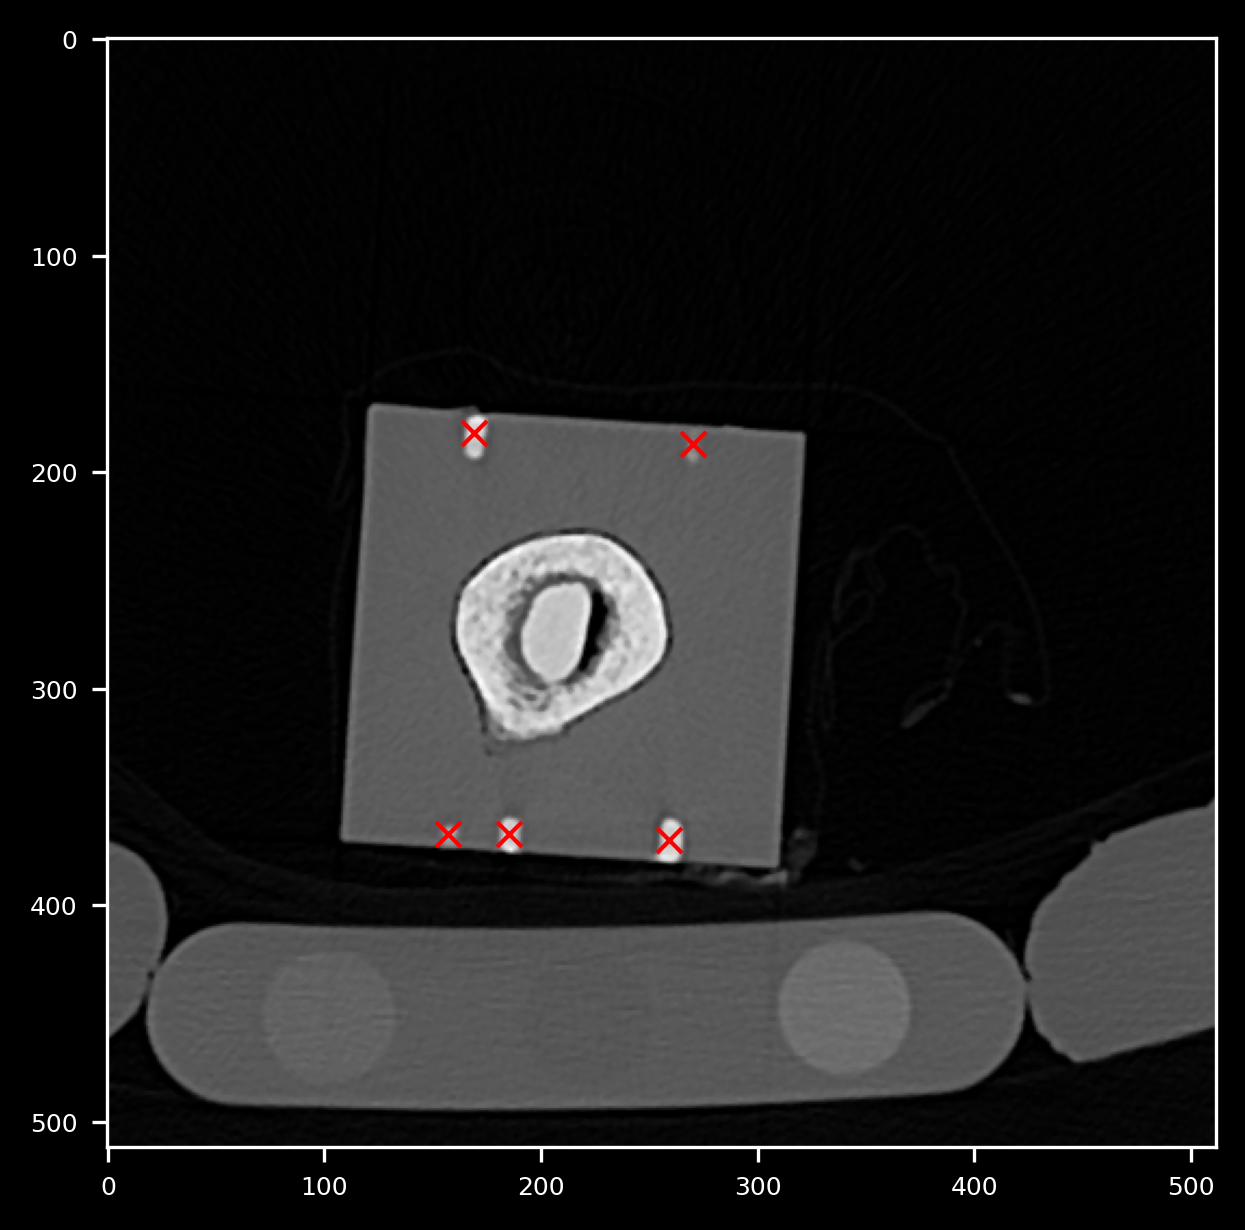

In [37]:
markers_slice = int(np.mean(markers_coordinates[:,2])/(data_3D_QCT_med.GetSpacing()[2]))
markers_pixel = (markers_coordinates / (np.array(data_3D_QCT_med.GetSpacing()))).astype('uint')

plt.imshow(sitk.GetArrayFromImage(data_3D_QCT_med)[markers_slice,:,:], cmap='grey')
plt.plot(markers_pixel[:,0], markers_pixel[:,1], 'xr')

###  Alignment and registration rotation matrices
Get n12, n14, v12, and v14 vectors

In [38]:
n12 = markers_coordinates[1,:] - markers_coordinates[0,:]
n14 = markers_coordinates[3,:] - markers_coordinates[0,:]

v12 = markers_coordinates_HR[1,:] - markers_coordinates_HR[0,:]
v14 = markers_coordinates_HR[3,:] - markers_coordinates_HR[0,:]

#### Rotation matrix to allign QCT markers with X-Y plane

In [62]:
# R_xy = align_with_XYplane(n12, n14)
# print(R_xy)

#### Rotation matrix to allign QCT markers with HR-pQCT markers

In [39]:
R_HR = align_with_vectors(n12, n14, v12, v14)
print(R_HR)

Angle between n12 and n14: 87.8401262367663 deg
Angle between v12 and v14: 89.13824661241422 deg
[[-0.16519038  0.98416107  0.06433598]
 [-0.98625611 -0.16461802 -0.01413481]
 [-0.00332007 -0.06578669  0.99782819]]


Store transformation matrix

In [41]:
output_R_HR = os.path.join(data_dir, 'QCT', ('QCT' + specimen.replace("_", "")), (specimen + '_R_HR.npy'))
print(output_R_HR)
np.save(output_R_HR, R_HR)

/usr/terminus/data-xrm-01/stamplab/external/tacosound/QCT/QCT1996R/1996_R_R_HR.npy


### Apply affine transformation to QCT stack

Apply the transformation matrix to the markers coordinates

In [42]:
print(markers_coordinates)

[[105.80471463  41.55843099  27.41550022]
 [ 76.06176769  38.38775648  26.5943001 ]
 [ 70.25288015  93.48073766  19.92700549]
 [ 99.33822058  97.15045474  20.62579751]
 [ 98.04740339  40.61198237  26.78841114]]


In [42]:
markers_coordinates_trans = np.matmul(markers_coordinates, R_HR)
print(markers_coordinates_trans)

[[-114.0106727    26.07369408   27.8321737 ]
 [-119.70545422   55.31113196   29.06265422]
 [ -67.31894938   67.39899873   27.35631991]
 [ -60.91205379   38.58367513   26.16375616]
 [-115.3160252    34.10421627   27.8482758 ]]


In [44]:
print(markers_coordinates_HR)

[[ 95.189 101.349  14.088]
 [ 97.79   71.475  13.904]
 [ 41.58   66.536  13.816]
 [ 38.808  96.226  14.028]
 [ 95.934  93.435  13.657]]


#### Transform dataset - align with HR-pQCT dataset
Apply the same transformation to:
1. data_3D_QCT     - QCT dataset
2. data_3D_QCT_med - median resampled version of QCT (for binary compartment masks calculation)

In [43]:
data_3D_QCT_trans = affine_trans(data_3D_QCT, tmatrix=R_HR) # R_1rot

In [46]:
print(data_3D_QCT_trans.GetSpacing())

(0.29296875000000006, 0.29296875000000006, 0.3033386327503974)


In [44]:
data_3D_QCT_med = affine_trans(data_3D_QCT_med, tmatrix=R_HR) # R_1rot

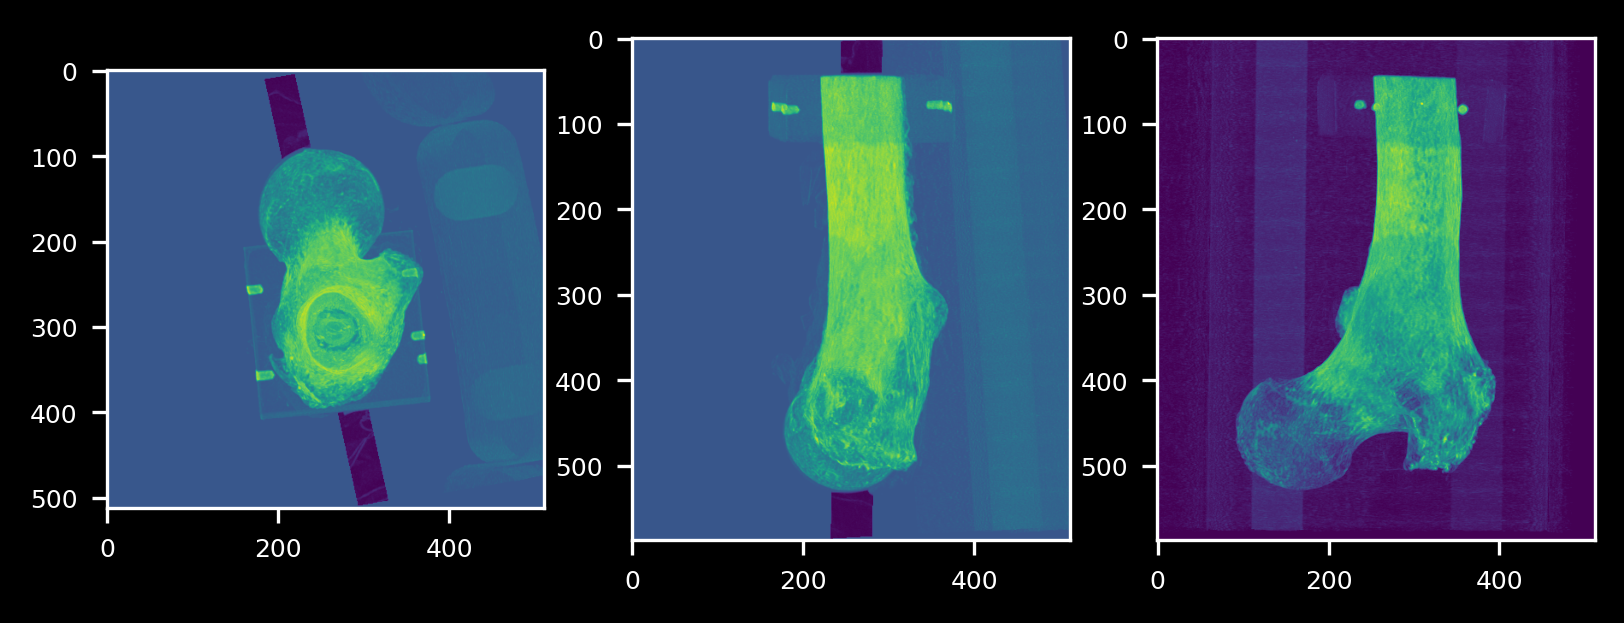

In [45]:
plot_projections_sitk(data_3D_QCT_trans)
# plot_projections_sitk(data_3D_QCT_med)

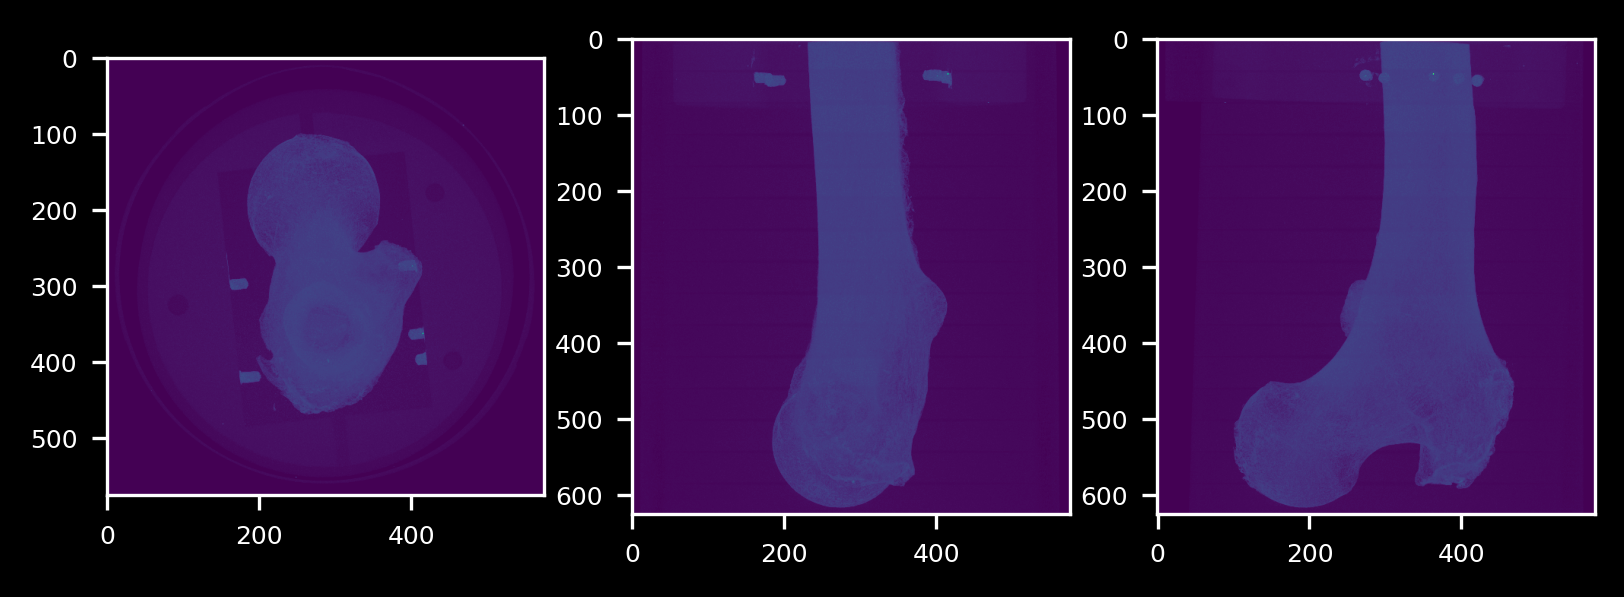

In [46]:
plot_projections_sitk(data_3D_res)

#### Recalculate markers coordinates on transformed QCT image

In [47]:
data_3D_QCT_BW_trans = morphology.binary_opening(sitk.GetArrayFromImage(data_3D_QCT_med) > ts[1])

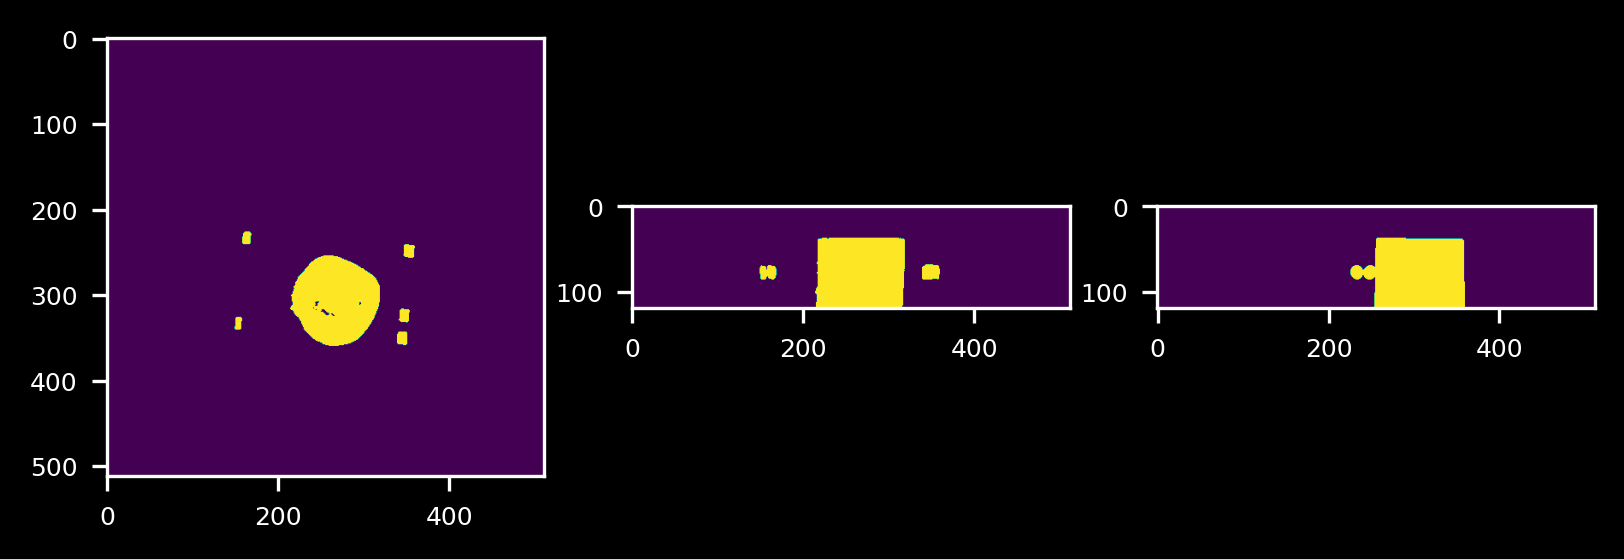

In [59]:
plot_projections(data_3D_QCT_BW_trans[0:120,:,:])

In [48]:
markers_coordinates_trans = markers_coors(data_3D_QCT_BW_trans[0:120,:,:]) # [z, y, x]
# multiply by voxelsize and flip
markers_coordinates_trans = np.fliplr(markers_coordinates_trans*data_3D_QCT_med.GetSpacing()) # [x, y, z]
print(markers_coordinates_trans)

[[107.95304582  98.8509366   24.52482128]
 [103.71078419  69.30190345  23.70042067]
 [ 50.29744444  75.08525374  24.55501967]
 [ 53.66738495 104.43366812  25.43626919]
 [106.51399454  90.8410554   23.97325944]]


Check correct position of markers coordinates on transformed image

In [49]:
markers_slice_trans = int(np.mean(markers_coordinates_trans[:,2])/data_3D_QCT_med.GetSpacing()[2])
markers_pixel_trans = (markers_coordinates_trans / data_3D_QCT_med.GetSpacing()).astype('uint')

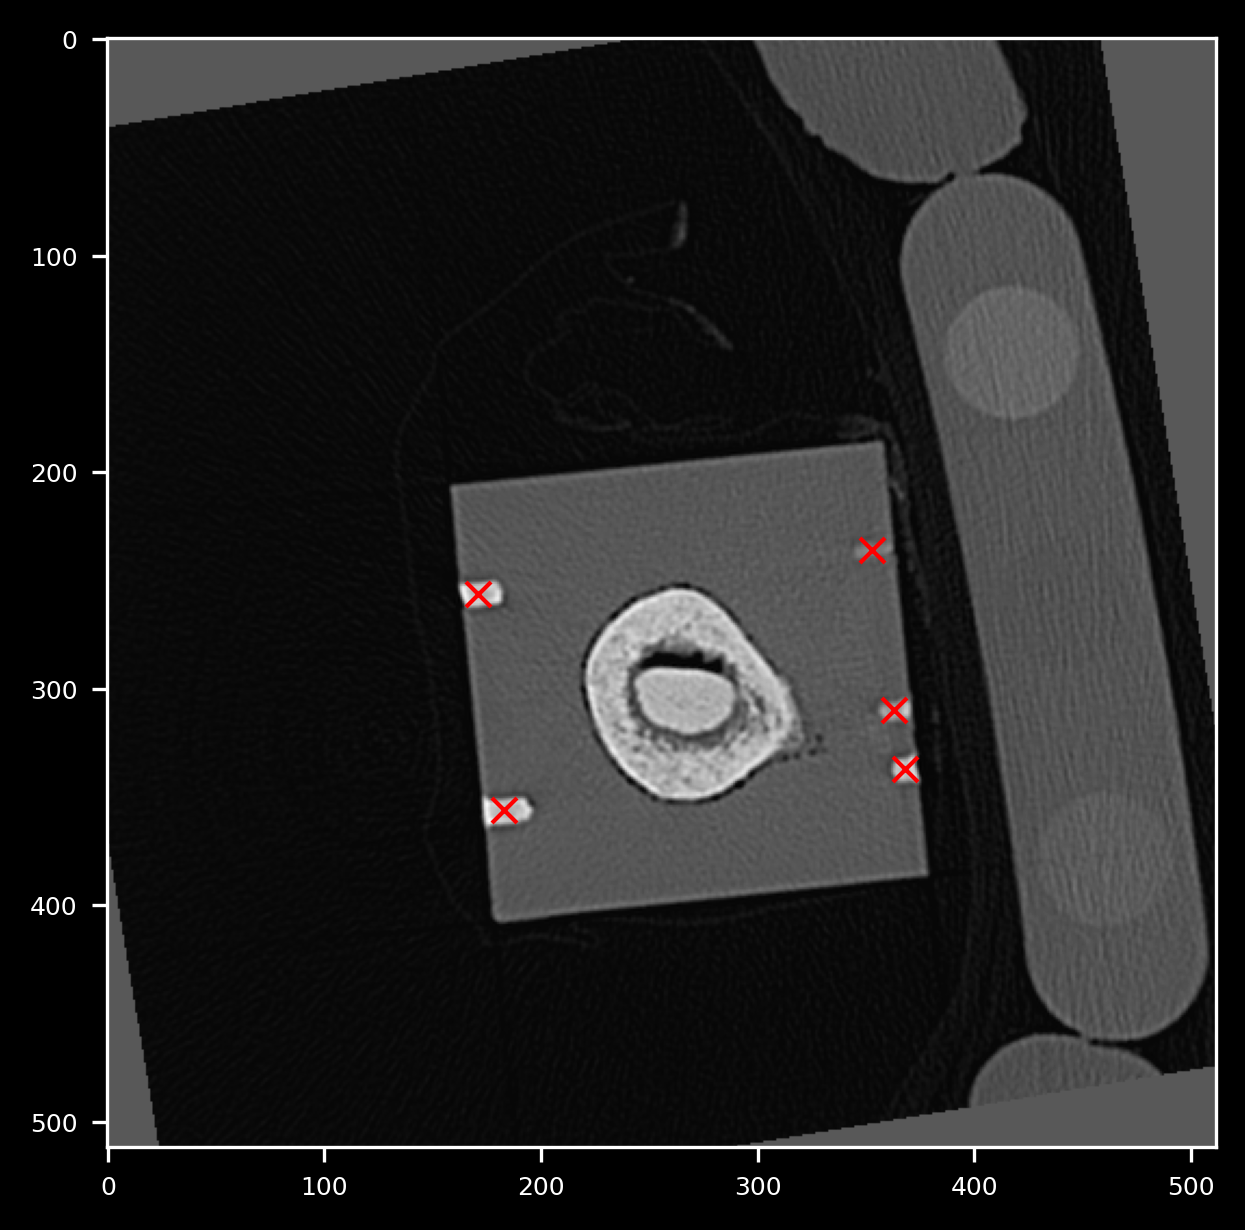

In [50]:
plt.imshow(sitk.GetArrayFromImage(data_3D_QCT_trans)[markers_slice_trans,:,:], cmap='grey')
plt.plot(markers_pixel_trans[:,0], markers_pixel_trans[:,1], 'xr')

#### Get offset between HR-pQCT and transformed QCT images

In [51]:
Offset_HR_QCTtrans = np.mean(markers_coordinates_HR - markers_coordinates_trans, axis=0)
print(Offset_HR_QCTtrans)

[ -8.03113079  -2.82456346 -12.36475805]


#### Fix QCT transformed image origin to include the offset

In [52]:
print('QCT transformed:')
print('Origin: ', data_3D_QCT_trans.GetOrigin())
print('Spacing: ', data_3D_QCT_trans.GetSpacing())

print('HR res:')
print('Origin: ', data_3D_res.GetOrigin())
print('Spacing: ', data_3D_res.GetSpacing())


QCT transformed:
Origin:  (-61.853515624999986, -166.853515625, -665.8000000000001)
Spacing:  (0.29296874999999994, 0.29296874999999994, 0.3051194539249146)
HR res:
Origin:  (0.0, 0.0, 13656.0)
Spacing:  (242.39930556, 242.39930556, 240.0)


In [53]:
data_3D_QCT_trans.SetOrigin(data_3D_QCT_trans.GetOrigin()+Offset_HR_QCTtrans)
# data_3D_QCT_med.SetOrigin(data_3D_QCT_med.GetOrigin()+Offset_HR_QCTtrans)

#### Set origin to zero and add the offset to HR markers

In [54]:
data_3D_QCT_trans.SetOrigin(Offset_HR_QCTtrans)

#### Write transformed dataset as single MHD file

In [55]:
# output_QCT_R_HR = os.path.join(data_dir, 'QCT/QCTFEMUR_1955L/QCTFEMUR_1955L_R_HR.mhd')
# output_QCT_R_HR = os.path.join(data_dir, 'QCT', ('QCTFEMUR_' + specimen.replace("_", "")), (specimen + '_R_HR.mhd'))
output_QCT_R_HR = os.path.join(data_dir, 'QCT', ('QCT' + specimen.replace("_", "")), (specimen + '_R_HR.mhd'))
print(output_QCT_R_HR)


/usr/terminus/data-xrm-01/stamplab/external/tacosound/QCT/QCT1996R/1996_R_R_HR.mhd


In [56]:
writer = sitk.ImageFileWriter()
writer.SetFileName(output_QCT_R_HR)
writer.Execute(data_3D_QCT_trans)

#### Write resampled HR dataset as MHD file

In [57]:
data_3D_res.SetOrigin([0.0, 0.0, 0.0])
data_3D_res.SetSpacing(1e-3 * np.array(data_3D_res.GetSpacing()))


In [58]:
output_file_HR_res = os.path.join(data_dir, 'HR-pQCT_II/00_resampled_data', specimen, (isqname + '_processed2.mhd'))
print(output_file_HR_res)

/usr/terminus/data-xrm-01/stamplab/external/tacosound/HR-pQCT_II/00_resampled_data/1996_R/C0001808_processed2.mhd


In [59]:
writer = sitk.ImageFileWriter()
writer.SetFileName(output_file_HR_res)
writer.Execute(data_3D_res)

## Elastix affine registration

`/home/giiori/myterminus/software/elastix5.1/bin/elastix -f /home/giiori/terminus/external/tacosound/HR-pQCT_II/00_resampled_data/2019_L/C0001524_processed2.mhd -m /home/giiori/terminus/external/tacosound/QCT/QCTFEMUR_2019L/2019_L_R_HR.mhd -out /home/giiori/terminus/external/tacosound/QCT/QCTFEMUR_2019L/ -p /home/giiori/myterminus/code/pyfabric/elastix/Parameters.Par0015.expC.phantom.NC.affine.txt`

### Affine registration using a fixed image mask

- I used the same procedure to register also dataset 1996_R
- I had to use a mask for the fixed image in addition (`-fMask` argument in `elastix`) to remove the bed with the QCT phantom and compute registration metrics only around the bone
- I drew manually the mask in `3Dslicer`
- I tested `MaximumNumberOfSamplingAttempts = 5, 10` (`NumberOfSpatialSamples = 2000, 4000`, respectively) and I see no difference in the result
- The registered image is in `/Volumes/stamplab_terminus/external/tacosound/QCT/QCT1996R/1996_R_R_HR_elastix_03/result.0.mhd`

`/home/giiori/myterminus/software/elastix5.1/bin/elastix -f /home/giiori/terminus/external/tacosound/HR-pQCT_II/00_resampled_data/1996_R/C0001808_processed2.mhd -m /home/giiori/terminus/external/tacosound/QCT/QCT1996R/1996_R_R_HR.mhd -fMask /home/giiori/terminus/external/tacosound/QCT/QCT1996R/1996_R_R_HR_mask.mhd -out /home/giiori/terminus/external/tacosound/QCT/QCT1996R/1996_R_R_HR_elastix_03/ -p /home/giiori/myterminus/code/pyfabric/elastix/Parameters.Par0015.expC.phantom.NC.affine2.txt`

---
# scratch: